In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", message=".*'M' is deprecated.*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*'Q-DEC' is deprecated.*", category=FutureWarning)

from utils import get_basedir, load_nlb_npl_data, fill_missing_values, resample_monthly_to_quarterly, compute_time_distance, get_eurostat_time_unit
from plotting_functions import plot_nlb_and_eurostat_data, plot_df_head_table, plot_model_coefficients_table, plot_abs_coeff_series_by_dataset, plot_npl_predictions


BASE_DIR = get_basedir()


# **Time Series Modelling**

**Author:** Ivan Kukuljan 
**Date:** October 14, 2025 

**Recruiting assignment at the NLB Group**

---

## Key findings {.unnumbered}

- Among macroeconomic variables, the Non-Performing Loans (NPL) are most strongly influenced by the Gross domestic product, Unemployment Rate and House price index
- The model correctly captures different NPL regimes - the Euro crisis and the post crisis period
- The model has a future predictive power of two quarters

## Abstract {.unnumbered}

Non-Performing Loans (NPL) is one the most important indicators in bank. It reflects loans where the borrowers have stopped making payments for an extended period. Here we model the dependence of the NPL of Nova Ljubljanska Banka on most important macroeconomic variables in the period of 2008-2022. We develop a linear model with delay. We test the model on two non-overlapping test sets: test set 1 - missing data inside of the modelling period, test set 2 - future period. The model achieves the $R^2$ score of 0.8645 inside of the modelling period, while it is only able to predict two quarters ahead in the future period. Gross domestic product, Unemployment Rate and House price index are identified as main macroeconomic drivers of the NPL.

## Data sets

The NPL data of Nova Ljubljanska Banka have been provided by NLB. They are quarterly data giving the date and the NLP values for the period 2008-2022. 

We choose the following set of macroeconomic variables from the Eurostat database:

- Gross domestic product (GDP) (2015 = 100) - nama_10_gdp, annual - representing health of the national economy
- Gross domestic product (GDP) (percentage change on previous) - nama_10_gdp, annual - representing the trend in the national economy
- Unemployment Rate - une_rt_q, quarterly
- House price index (2015 = 100) - prc_hpi_q, quarterly
- Harmonised Index of Consumer Prices (annual rate of change) - prc_hicp_manr, monthly
- Private sectror credit flow - tipspc10, annual
- Money Market Interest Rate - irt_st_m, monthly
- Consumer confidence indicator - ei_bsco_m, monthly

We have considered several other macroeconomic variables, like Government deficit/surplus, Consumer confidence - financial last 12 months, Consumer confidence - financial next 12 months. However, they have turned out to have less influence on the NPL.

NLB is operating on a wide market, consisting of Slovenia, Serbia, Croatia, Bosnia and Herzegovina, Macedonia, Montenegro and Kosovo. Unfortunately, since not all of these countries are member states of the EU, Eurostat is not keeping consistent statistics of all of them. While some data sets are available fo some of them, many data sets are missing, or have only been kept in the recent years. For simplicity, we therefore choose to model the NPL using macroeconomic variables for Slovenia, where 62% of NLB's banking assets are located [NLB Group Presentation, 1H 2025 Financial Results]. 

The time series of the NLB NPL rates as well as the chosen macroeconomic variables are shown in the Figure 1 below.

The chosen data sets have different frequencies. For consistency and in order to reduce the number of parameters of the model, we choose to transform monthly datasets into quarterly. Annual data sets are treated as annual as described below. For the stability of the model, we scale the data sets to have zero mean and unit variance. 

We split the data into non-overlapping train set and two test sets. The train set and the test set 1 are randomly split data entries for the period 2008 until 2021-Q2. The test set 2 consists of all the data entries for the period 2021-Q3 until 2022-Q4. The purpose of the test set 1 is to test the validity of the model inside of the period where it has been optimized. The purpose of the test set 2 is to test the performance of the model for the future predictions. 


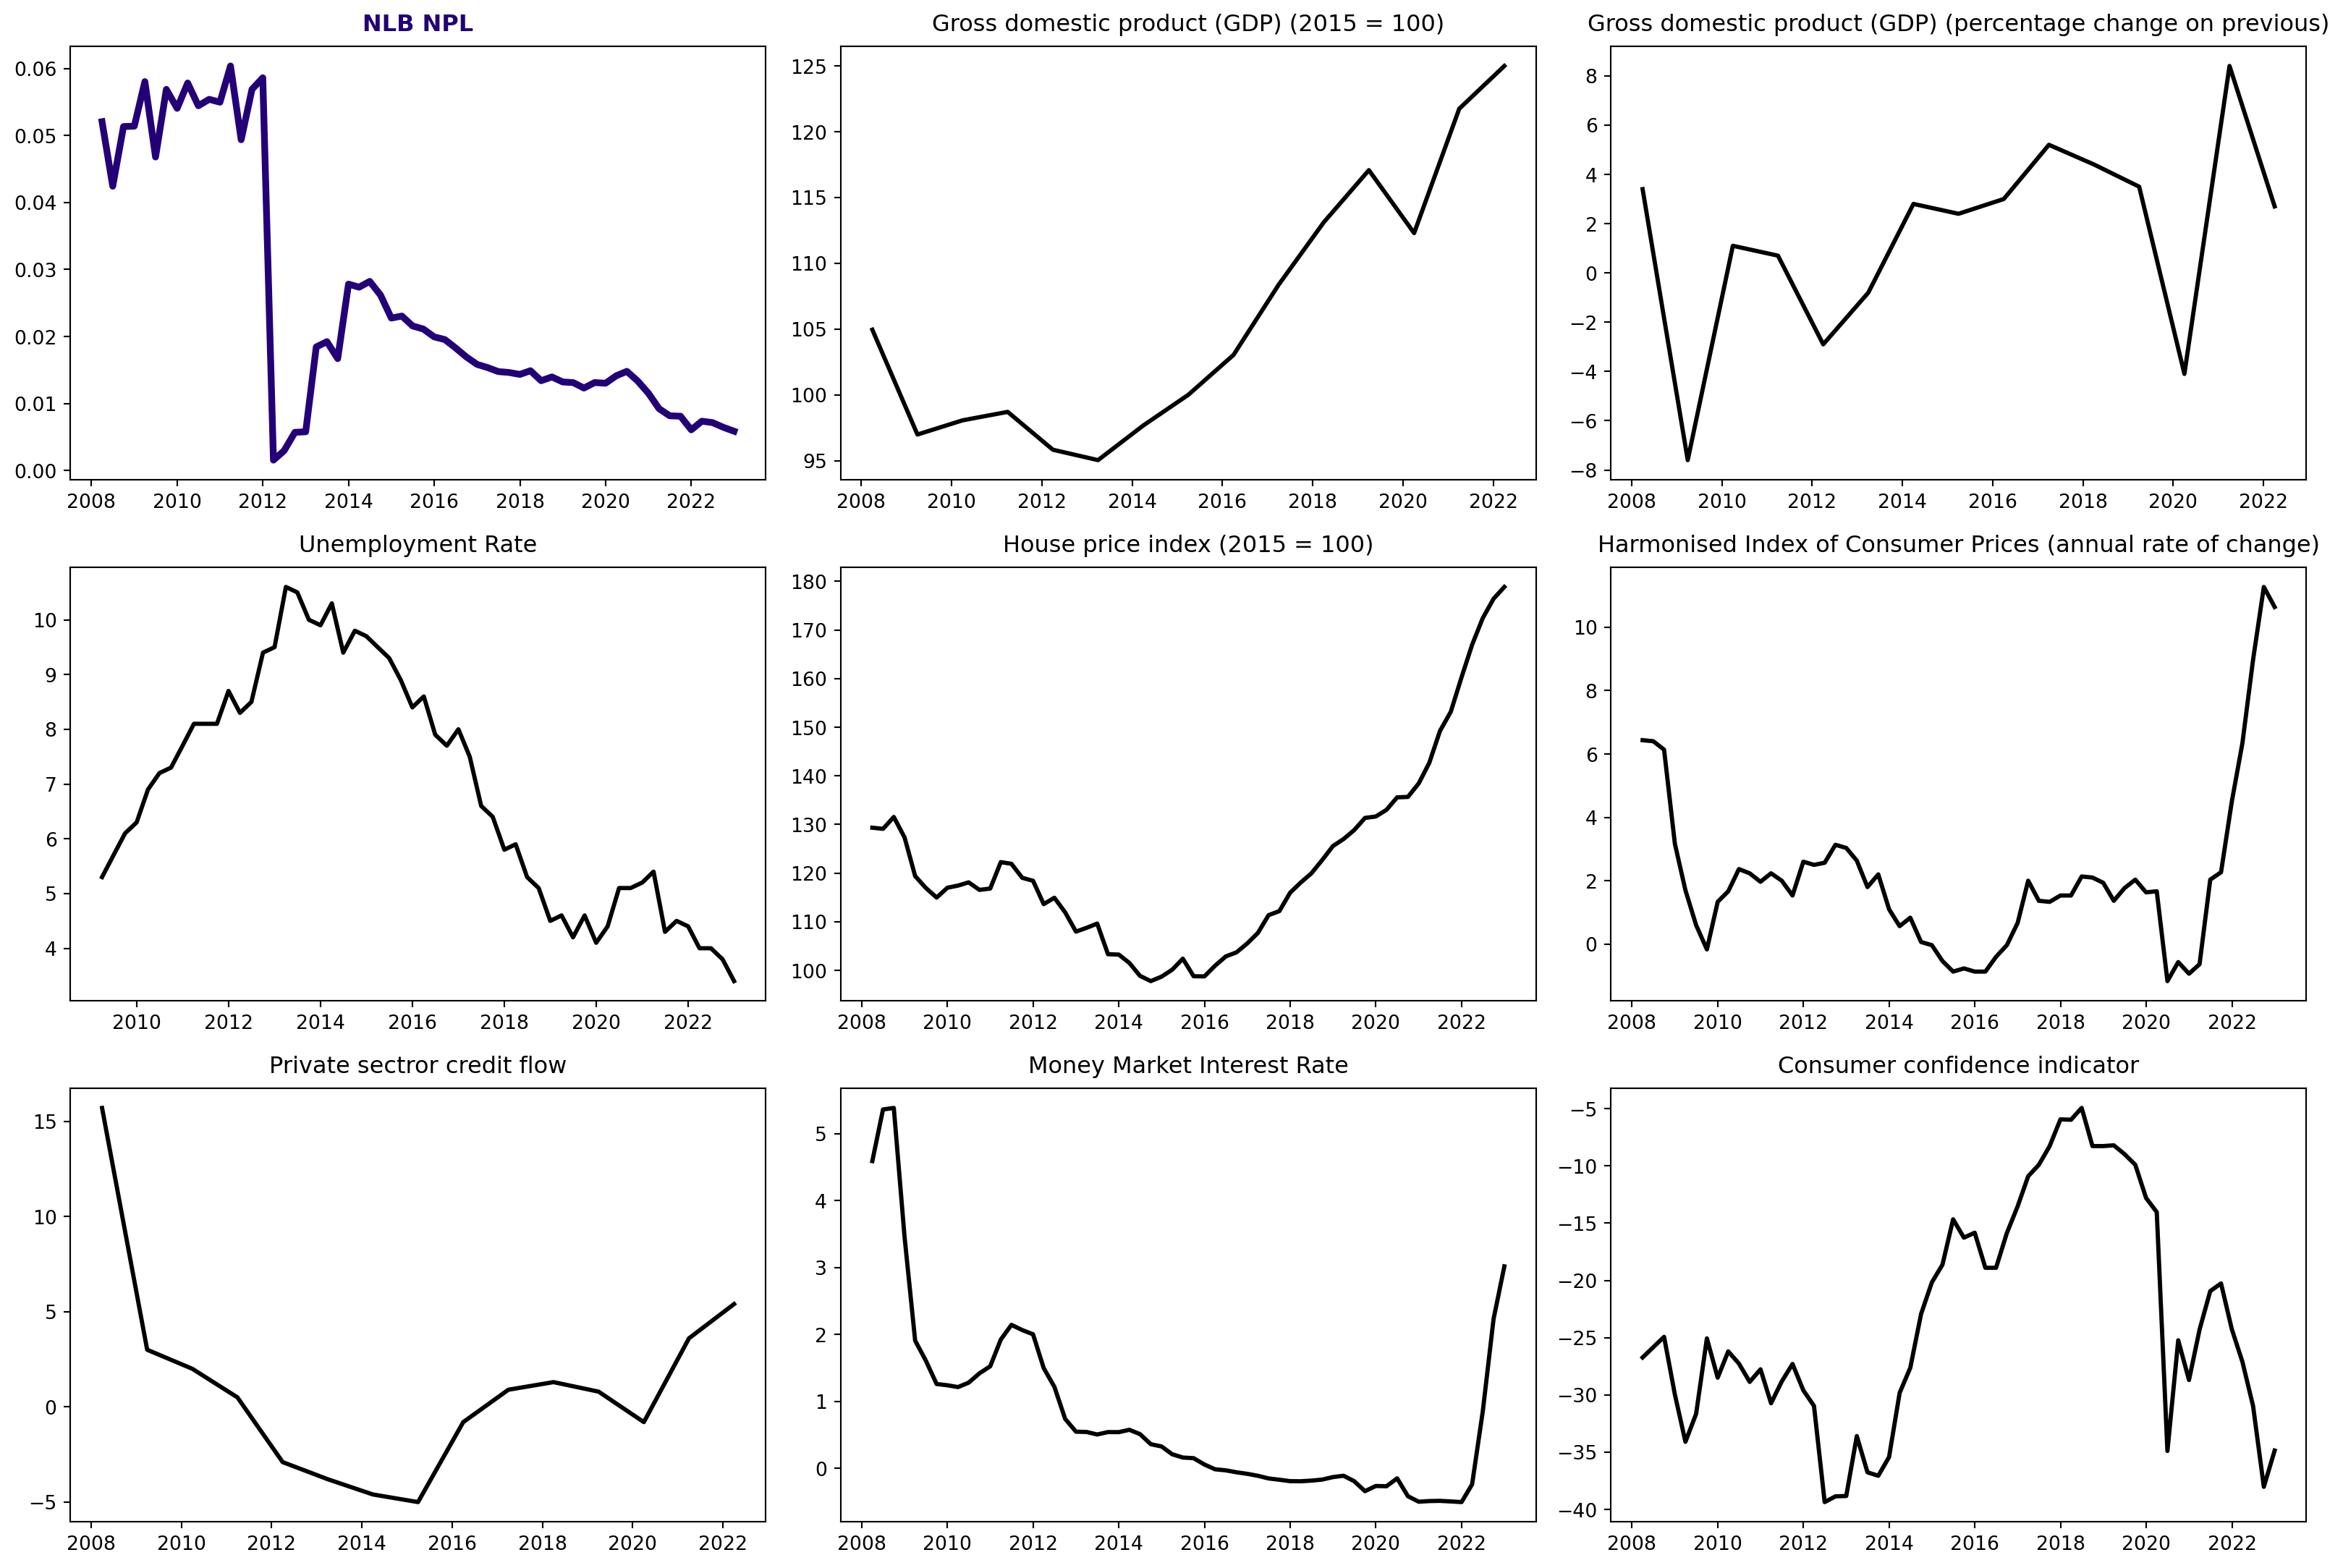

In [2]:

eurostat_datasets = {'Gross domestic product (GDP) (2015 = 100)' :
{'dataset_code' : 'nama_10_gdp',
'frequency' : 'a',
'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nama_10_gdp/1.0/*.*.*.*?c[freq]=A&c[unit]=CLV_I15&c[na_item]=B1GQ&c[geo]=SI&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
'unit_column_name' : 'Unit of measure',
'fill_missing' : True},

'Gross domestic product (GDP) (percentage change on previous)' :    
{'dataset_code' : 'nama_10_gdp',
'frequency' : 'a',
'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nama_10_gdp/1.0/*.*.*.*?c[freq]=A&c[unit]=CLV_PCH_PRE&c[na_item]=B1GQ&c[geo]=SI&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
'unit_column_name' : 'Unit of measure',
'fill_missing' : True},

 'Unemployment Rate' :
 {'dataset_code' : 'une_rt_q',
 'frequency' : 'q',
 'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/une_rt_q/1.0/*.*.*.*.*.*?c[freq]=Q&c[s_adj]=SA&c[age]=Y20-64&c[unit]=PC_ACT&c[sex]=T&c[geo]=SI&c[TIME_PERIOD]=ge:2006-Q1+le:2023-Q4&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
 'unit_column_name' : 'Unit of measure',
 'fill_missing' : False},

 'House price index (2015 = 100)' : 
 {'dataset_code' : 'prc_hpi_q',
 'frequency' : 'q',
 'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/prc_hpi_q/1.0/*.*.*.*?c[freq]=Q&c[purchase]=TOTAL&c[unit]=I15_Q&c[geo]=SI&c[TIME_PERIOD]=2023-Q4,2023-Q3,2023-Q2,2023-Q1,2022-Q4,2022-Q3,2022-Q2,2022-Q1,2021-Q4,2021-Q3,2021-Q2,2021-Q1,2020-Q4,2020-Q3,2020-Q2,2020-Q1,2019-Q4,2019-Q3,2019-Q2,2019-Q1,2018-Q4,2018-Q3,2018-Q2,2018-Q1,2017-Q4,2017-Q3,2017-Q2,2017-Q1,2016-Q4,2016-Q3,2016-Q2,2016-Q1,2015-Q4,2015-Q3,2015-Q2,2015-Q1,2014-Q4,2014-Q3,2014-Q2,2014-Q1,2013-Q4,2013-Q3,2013-Q2,2013-Q1,2012-Q4,2012-Q3,2012-Q2,2012-Q1,2011-Q4,2011-Q3,2011-Q2,2011-Q1,2010-Q4,2010-Q3,2010-Q2,2010-Q1,2009-Q4,2009-Q3,2009-Q2,2009-Q1,2008-Q4,2008-Q3,2008-Q2,2008-Q1,2007-Q4,2007-Q3,2007-Q2,2007-Q1,2006-Q4,2006-Q3,2006-Q2,2006-Q1&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
 'unit_column_name' : 'Unit of measure',
 'fill_missing' : True},

 'Harmonised Index of Consumer Prices (annual rate of change)':
 {'dataset_code' : 'prc_hicp_manr',
 'frequency' : 'm',
 'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/prc_hicp_manr/1.0/*.*.*.*?c[freq]=M&c[unit]=RCH_A&c[coicop]=CP00&c[geo]=SI&c[TIME_PERIOD]=2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,2022-05,2022-04,2022-03,2022-02,2022-01,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,2021-03,2021-02,2021-01,2020-12,2020-11,2020-10,2020-09,2020-08,2020-07,2020-06,2020-05,2020-04,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,2018-02,2018-01,2017-12,2017-11,2017-10,2017-09,2017-08,2017-07,2017-06,2017-05,2017-04,2017-03,2017-02,2017-01,2016-12,2016-11,2016-10,2016-09,2016-08,2016-07,2016-06,2016-05,2016-04,2016-03,2016-02,2016-01,2015-12,2015-11,2015-10,2015-09,2015-08,2015-07,2015-06,2015-05,2015-04,2015-03,2015-02,2015-01,2014-12,2014-11,2014-10,2014-09,2014-08,2014-07,2014-06,2014-05,2014-04,2014-03,2014-02,2014-01,2013-12,2013-11,2013-10,2013-09,2013-08,2013-07,2013-06,2013-05,2013-04,2013-03,2013-02,2013-01,2012-12,2012-11,2012-10,2012-09,2012-08,2012-07,2012-06,2012-05,2012-04,2012-03,2012-02,2012-01,2011-12,2011-11,2011-10,2011-09,2011-08,2011-07,2011-06,2011-05,2011-04,2011-03,2011-02,2011-01,2010-12,2010-11,2010-10,2010-09,2010-08,2010-07,2010-06,2010-05,2010-04,2010-03,2010-02,2010-01,2009-12,2009-11,2009-10,2009-09,2009-08,2009-07,2009-06,2009-05,2009-04,2009-03,2009-02,2009-01,2008-12,2008-11,2008-10,2008-09,2008-08,2008-07,2008-06,2008-05,2008-04,2008-03,2008-02,2008-01,2007-12,2007-11,2007-10,2007-09,2007-08,2007-07,2007-06,2007-05,2007-04,2007-03,2007-02,2007-01,2006-12,2006-11,2006-10,2006-09,2006-08,2006-07,2006-06,2006-05,2006-04,2006-03,2006-02,2006-01&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
 'unit_column_name' : 'Unit of measure',
 'resample_method' : 'mean',
 'fill_missing' : True},

 'Private sectror credit flow':
 {'dataset_code' : 'tipspc10',
 'frequency' : 'a',
 'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/tipspc10/1.0/*.*.*.*.*.*.*?c[freq]=A&c[co_nco]=CO&c[sector]=S11_S14_S15&c[finpos]=LIAB&c[na_item]=F3_F4&c[unit]=PC_GDP&c[geo]=SI&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
 'unit_column_name' : 'Unit of measure',
 'fill_missing' : True},    

 'Money Market Interest Rate' : 
 {'dataset_code' : 'irt_st_m',
 'frequency' : 'm',
 'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/irt_st_m/1.0/*.*.*?c[freq]=M&c[int_rt]=IRT_M12&c[geo]=EA&c[TIME_PERIOD]=2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,2022-05,2022-04,2022-03,2022-02,2022-01,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,2021-03,2021-02,2021-01,2020-12,2020-11,2020-10,2020-09,2020-08,2020-07,2020-06,2020-05,2020-04,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,2018-02,2018-01,2017-12,2017-11,2017-10,2017-09,2017-08,2017-07,2017-06,2017-05,2017-04,2017-03,2017-02,2017-01,2016-12,2016-11,2016-10,2016-09,2016-08,2016-07,2016-06,2016-05,2016-04,2016-03,2016-02,2016-01,2015-12,2015-11,2015-10,2015-09,2015-08,2015-07,2015-06,2015-05,2015-04,2015-03,2015-02,2015-01,2014-12,2014-11,2014-10,2014-09,2014-08,2014-07,2014-06,2014-05,2014-04,2014-03,2014-02,2014-01,2013-12,2013-11,2013-10,2013-09,2013-08,2013-07,2013-06,2013-05,2013-04,2013-03,2013-02,2013-01,2012-12,2012-11,2012-10,2012-09,2012-08,2012-07,2012-06,2012-05,2012-04,2012-03,2012-02,2012-01,2011-12,2011-11,2011-10,2011-09,2011-08,2011-07,2011-06,2011-05,2011-04,2011-03,2011-02,2011-01,2010-12,2010-11,2010-10,2010-09,2010-08,2010-07,2010-06,2010-05,2010-04,2010-03,2010-02,2010-01,2009-12,2009-11,2009-10,2009-09,2009-08,2009-07,2009-06,2009-05,2009-04,2009-03,2009-02,2009-01,2008-12,2008-11,2008-10,2008-09,2008-08,2008-07,2008-06,2008-05,2008-04,2008-03,2008-02,2008-01,2007-12,2007-11,2007-10,2007-09,2007-08,2007-07,2007-06,2007-05,2007-04,2007-03,2007-02,2007-01,2006-12,2006-11,2006-10,2006-09,2006-08,2006-07,2006-06,2006-05,2006-04,2006-03,2006-02,2006-01&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
 'unit_column_name' : 'Interest rate',
 'resample_method' : 'last',
 'fill_missing' : True},

 'Consumer confidence indicator':
 {'dataset_code' : 'ei_bsco_m',
 'frequency' : 'm',
 'url' : 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/ei_bsco_m/1.0/*.*.*.*.*?c[freq]=M&c[indic]=BS-CSMCI&c[s_adj]=SA&c[unit]=BAL&c[geo]=SI&c[TIME_PERIOD]=2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,2022-05,2022-04,2022-03,2022-02,2022-01,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,2021-03,2021-02,2021-01,2020-12,2020-11,2020-10,2020-09,2020-08,2020-07,2020-06,2020-05,2020-04,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,2018-02,2018-01,2017-12,2017-11,2017-10,2017-09,2017-08,2017-07,2017-06,2017-05,2017-04,2017-03,2017-02,2017-01,2016-12,2016-11,2016-10,2016-09,2016-08,2016-07,2016-06,2016-05,2016-04,2016-03,2016-02,2016-01,2015-12,2015-11,2015-10,2015-09,2015-08,2015-07,2015-06,2015-05,2015-04,2015-03,2015-02,2015-01,2014-12,2014-11,2014-10,2014-09,2014-08,2014-07,2014-06,2014-05,2014-04,2014-03,2014-02,2014-01,2013-12,2013-11,2013-10,2013-09,2013-08,2013-07,2013-06,2013-05,2013-04,2013-03,2013-02,2013-01,2012-12,2012-11,2012-10,2012-09,2012-08,2012-07,2012-06,2012-05,2012-04,2012-03,2012-02,2012-01,2011-12,2011-11,2011-10,2011-09,2011-08,2011-07,2011-06,2011-05,2011-04,2011-03,2011-02,2011-01,2010-12,2010-11,2010-10,2010-09,2010-08,2010-07,2010-06,2010-05,2010-04,2010-03,2010-02,2010-01,2009-12,2009-11,2009-10,2009-09,2009-08,2009-07,2009-06,2009-05,2009-04,2009-03,2009-02,2009-01,2008-12,2008-11,2008-10,2008-09,2008-08,2008-07,2008-06,2008-05,2008-04,2008-03,2008-02,2008-01,2007-12,2007-11,2007-10,2007-09,2007-08,2007-07,2007-06,2007-05,2007-04,2007-03,2007-02,2007-01,2006-12,2006-11,2006-10,2006-09,2006-08,2006-07,2006-06,2006-05,2006-04,2006-03,2006-02,2006-01&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',
 'unit_column_name' : 'Unit of measure',
 'resample_method' : 'mean',
 'fill_missing' : True}
                    }


def retrieve_eurostat_dataset(dataset_dict):
    """
    Loads, checks, cleans, rescales, and adds useful fields for a Eurostat dataset.

    Parameters
    ----------
    dataset_dict : dict
        Must contain at least:
            - 'url': csv file location
            - 'fill_missing': value or None to use for missing fills
            - 'resample_method': 'mean' or 'last' if resampling is required

    Returns
    -------
    dataset_dict : dict
        Updated in place to contain:
            - 'times': list of period labels (str or yy-mm/yy-q)
            - 'values': list of values, as originally present
            - 'scaled_values': normalized values (zero mean/unit variance)
            - 'scaler_mean', 'scaler_scale': mean/scale used to standardize
        Or None upon error.
    """
    url = dataset_dict['url']  # Path to the raw Eurostat CSV data
    time_column_name = 'TIME_PERIOD'        # Name of the time column
    value_column_name = 'OBS_VALUE'         # Name of the value column
    country_column_name = 'Geopolitical entity (reporting)'  # Name of the country col
    

    # Load the CSV file into a DataFrame
    df = pd.read_csv(url)

    # Ensure the dataset only covers a single country (before resampling)
    if country_column_name in df.columns:
        countries = pd.unique(df[country_column_name].dropna())
        if len(countries) > 1:
            print('Error: more than one country in the dataset')
            return None
        if len(countries) == 0:
            print('Error: no country in the dataset')
            return None

    # Fill missing values if a fill_missing policy is specified
    if dataset_dict['fill_missing'] is not None:
        df = fill_missing_values(df, dataset_dict['fill_missing'])

    # Resample to quarterly, monthly, or other target frequency if needed
    if dataset_dict.get('resample_method'):
        df = resample_monthly_to_quarterly(
            df,
            resampling_perscription=dataset_dict['resample_method'],
            fill_missing=dataset_dict['fill_missing']
        )

    # Extract "times" and "values" to lists from the (possibly resampled) DataFrame
    times = df[time_column_name].tolist()
    values = df[value_column_name].tolist()

    # Convert original values to floating point numpy array for scaling
    vals = pd.to_numeric(df[value_column_name], errors='coerce').to_numpy()

    # Standardize the series (zero mean, unit variance)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled = scaler.fit_transform(vals.reshape(-1, 1)).ravel()

    # Attach processed arrays and stats to the dictionary (side-effect!)
    dataset_dict['times'] = times
    dataset_dict['values'] = values
    dataset_dict['scaled_values'] = scaled.tolist()
    dataset_dict['scaler_mean'] = float(scaler.mean_[0])
    dataset_dict['scaler_scale'] = float(scaler.scale_[0])

    return dataset_dict

for key in eurostat_datasets:
    dataset_dict = eurostat_datasets[key]
    dataset_dict = retrieve_eurostat_dataset(dataset_dict)
    eurostat_datasets[key] = dataset_dict

plot_nlb_and_eurostat_data(eurostat_datasets, output_path=os.path.join(BASE_DIR, 'plots', 'data_plots.png'))  


**Figure 1.** Time series of the Non-Performing Loans (NPL) of Nova Ljubljanska Banka (NLB) for the period 2008-2022 and the macroeconomic variables from the Eurostat database chosen for the modelling of the NPL.

## Model

We choose to model the NPL using the macroeconomic variables with a linear model with delayed action. There are two important reasons for choosing a linear model:

- A linear model offers a large amount of **explainability** and **interpretability**. In particular it allows us to easily extract the importance of different macroeconomic variables.
- A linear model is the most **robust** choice given that the NPL dataset is rather small consisting of only 60 data points. A more complex nonlinear model would come with a much larger set of parameters making it impossible to extract them without huge errors or even making the set of equations undetermined.

We build the following model:
$$
\begin{align}
\text{NPL}(t) &= \text{offset} + \sum_{d=1}^{D_{\text{NPL}}} K_{t-d}^{\text{NPL}}\cdot \text{NPL}(t-d) \\
&\quad + \sum_{\text{quarterly variables}}\sum_{d=0}^{D_{\text{quarterly}}} K_{t-d}^{\text{var.}}\cdot \text{variable}(t-d) \\
&\quad + \sum_{\text{annual variables}}\sum_{d=0}^{D_{\text{annual}}} K_{t-d}^{\text{var.}}\cdot \text{variable}(t-d)
\end{align}
$$

where $D_{\text{NPL}}$,  $D_{\text{quarterly}}$, $D_{\text{annual}}$ are the maximal delays for the corresponding variable. They represent the window in which the past values of the variables can influence the current value of NPL. Our analysis at different values of the delay parameters has shown that the model performs best at $D_{\text{NPL}}=2\text{ quarters}$,  $D_{\text{quarterly}}=2\text{ quarters}$, $D_{\text{annual}}=1\text{ year}$. This means that the value of NPL is dependent on the value of itself and quarterly variables from the period of up to 2 quarters (6 months) in the past and on the annual variables for up to a year in the past. The coefficients $K_{\tau}^{\alpha}$ and offset are parameters of the model that are determined through the optimization - linear regression.

Our data manipulation proceeds by collecting NPL time points and all the variables values that are within the windows allowed by the delays. This is completed by the code below and the first few rows of such an object are presented in the Table 1.

In [3]:
def compose_modelling_data(
        eurostat_datasets,
        scale=True,
        impute=True,
        nlb_window=2,
        months_window=6,
        quarters_window=2,
        annual_window=1,
        data_output_folder=os.path.join(BASE_DIR, 'plots'),
        ):
    """
    Construct and return a modelling DataFrame that integrates NLB's non-performing loan (NPL) data 
    with a collection of Eurostat macroeconomic datasets, assembled in a format suitable for 
    time series regression and forecasting tasks. This function offers flexible processing options, 
    including data standardization (scaling), missing-value imputation, inclusion of lagged feature 
    variables at multiple frequencies (monthly, quarterly, annual), and intermediate caching of the 
    resulting DataFrame to disk for efficient repeated usage.

    Main workflow:
        - Loads the NLB NPL time series, aligning it with its calendar dates for use as both target and lagged features.
        - Accepts a set of Eurostat datasets (already harmonized to similar frequencies), each of which may be processed into a feature set with time-aligned observations.
        - Optionally produces lagged input features for the NPL time series as predictors (e.g., last nlb_window quarters), as well as lagged features of the Eurostat datasets at varying window sizes for each frequency: months, quarters, and years.
        - Supports missing-value imputation using pandas' fill-forward/backward mechanisms, if enabled.
        - Standardizes input features (and optionally the target/lagged target) to zero mean and unit variance if `scale` is True.
        - If an output version of the assembled dataset (with current settings) is already saved to disk as a CSV, loads and returns it for efficiency; otherwise, computes anew and saves the resulting DataFrame.
        - Produces a final DataFrame indexed by date, with columns for the NPL target variable and all feature columns, harmonized for downstream modelling.

    Parameters
    ----------
    eurostat_datasets : dict
        Mapping from Eurostat variable names (str) to dataset dictionaries as returned by 
        standardization/processing pipeline.
    scale : bool, default True
        If True, standardize all time series variables (zero mean, unit variance).
    impute : bool, default True
        If True, fill missing values using forward/backward-fill; if False, leave NaNs where present.
    nlb_window : int, default 2
        Number of previous quarters of NPL data to include as lagged features.
    months_window : int, default 9
        Number of previous months for which to add lagged Eurostat features.
    quarters_window : int, default 3
        Number of previous quarters for which to add lagged Eurostat features.
    annual_window : int, default 1
        Number of previous years for which to add lagged Eurostat features.
    nlb_npl_data_path : str
        Path to Excel file containing the original NLB NPL data.
    data_output_folder : str
        Output folder for storing/reading cached modelling DataFrames.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to a specific point in time (indexed by date, typically by quarter),
        and each column represents a variable used in the modelling task. The columns include:
            - 'npl': The target variable, i.e., the observed value of NLB's non-performing loans at each date.
            - 'npl-1q', 'npl-2q', ...: Lagged values of the NPL series, with each column representing the NPL value from a previous quarter (up to `nlb_window` lags).
            - '[Eurostat series name]-[lag][unit]': Lagged features from Eurostat datasets, where each column corresponds to a particular macroeconomic indicator, shifted backward by a certain lag (with the unit 'm' for months, 'q' for quarters, or 'y' for years, and the lag amount varies according to the settings for months_window, quarters_window, and annual_window).
            - Additional columns result from all constructed lagged features for the given macroeconomic datasets and lag windows.
        Each row contains all feature values (and possibly standardized/scaled and/or imputed versions, depending on function arguments) for the same date, aligned for supervised modelling.
    """

    # Ensure the output folder exists
    if not os.path.exists(data_output_folder):
        os.makedirs(data_output_folder)

    # Select output file name depending on scale/impute settings
    if scale:
        if impute:
            data_output_name = (
                f'data_nlb_window_{nlb_window}_months_window_{months_window}'
                f'_quarters_window_{quarters_window}_annual_window_{annual_window}_scaled_imputed.csv'
            )
        else:
            data_output_name = (
                f'data_nlb_window_{nlb_window}_months_window_{months_window}'
                f'_quarters_window_{quarters_window}_annual_window_{annual_window}_scaled.csv'
            )
    else:
        if impute:
            data_output_name = (
                f'data_nlb_window_{nlb_window}_months_window_{months_window}'
                f'_quarters_window_{quarters_window}_annual_window_{annual_window}_imputed.csv'
            )
        else:
            data_output_name = (
                f'data_nlb_window_{nlb_window}_months_window_{months_window}'
                f'_quarters_window_{quarters_window}_annual_window_{annual_window}.csv'
            )

    data_output_path = os.path.join(data_output_folder, data_output_name)

    # If the data is already saved, just load and return it
    if os.path.exists(data_output_path):
        return pd.read_csv(data_output_path, index_col='date', parse_dates=['date'])
    else:
        # --- Read and initialize NLB NPL data ---
        nlb_dates, nlb_npl_values = load_nlb_npl_data()
        
        # Initialize DataFrame with index as nlb_dates
        data = pd.DataFrame(index=nlb_dates)
        data['npl'] = nlb_npl_values

        # Optionally construct lagged NPL features (by quarter, for nlb_window lag length)
        if nlb_window > 0:
            for i in range(1, nlb_window + 1):
                data[f'npl-{i}q'] = data['npl'].shift(i)

        # Forward/backward-fill NPL lags if imputation is requested
        if impute:
            lag_cols = [f'npl-{i}q' for i in range(1, nlb_window + 1)]
            data[lag_cols] = data[lag_cols].ffill().bfill()

        # --- Add Eurostat datasets as covariates (with appropriate history windows) ---
        dataset_names = eurostat_datasets.keys()
        for dataset_name in dataset_names:
            dataset_data = eurostat_datasets[dataset_name]
            dataset_times = dataset_data['times']

            # Choose scaled or raw Eurostat values
            if scale:
                dataset_values = dataset_data['scaled_values']
            else:
                dataset_values = dataset_data['values']

            # Determine the time unit for the current dataset (yearly, quarterly, or monthly)
            times_unit = get_eurostat_time_unit(dataset_times[0])

            # Select the rolling window based on the time unit
            if times_unit == 'y':
                time_window = annual_window
            elif times_unit == 'q':
                time_window = quarters_window
            elif times_unit == 'm':
                time_window = months_window
            else:
                raise ValueError(f"Unrecognized Eurostat time unit: '{times_unit}'")

            # Create lag columns for this dataset, for window size (0 latest to N lags back)
            for i in range(time_window + 1):
                colname = f'{dataset_name}-{i}{times_unit}'
                data[colname] = np.nan  # initialize with NaN

                # For each NLB date, attempt to match with a corresponding Eurostat date at lag -i
                for nlb_date in nlb_dates:
                    for dataset_time in dataset_times:
                        # compute_time_distance returns negative for the past
                        if compute_time_distance(nlb_date, dataset_time) == -i:
                            # Uncomment next line for trace debugging
                            # print(f'time distance: {i}, nlb_date: {nlb_date}, dataset_time: {dataset_time}')
                            data.loc[nlb_date, colname] = dataset_values[dataset_times.index(dataset_time)]
                            break

            # --- Imputation logic for missing Eurostat data ---
            if impute:
                if dataset_name == 'Unemployment Rate':
                    # For 'Unemployment Rate', do special linear extrapolation (backwards)
                    for i in range(time_window + 1):
                        col = f'{dataset_name}-{i}{times_unit}'
                        # Avoid going out of bounds with j+1 and j+2 (iterate until 2 from bottom)
                        for j in range(len(data) - 2):
                            # If current is nan and next is not nan, try to extrapolate
                            if pd.isna(data.iloc[j][col]) and not pd.isna(data.iloc[j + 1][col]):
                                start_value = data.iloc[j + 1][col]
                                next_value = data.iloc[j + 2][col]

                                # If next value is nan too, can't do linear extrapolation
                                if pd.isna(next_value):
                                    continue

                                # The difference (slope) for backwards linear fill
                                delta = start_value - next_value

                                # Fill all consecutive nans back as a line
                                for k in range(j, -1, -1):
                                    if pd.isna(data.iloc[k][col]):
                                        # The further back, the further from start_value by slope times (j+1-k)
                                        data.iloc[k, data.columns.get_loc(col)] = start_value + delta * (j + 1 - k)
                                    else:
                                        # Stop when hit a non-nan value further back
                                        break
                else:
                    # For all other datasets, fill forward then backward using nearest values
                    for i in range(time_window + 1):
                        col = f'{dataset_name}-{i}{times_unit}'
                        if col in data.columns:
                            data[col] = data[col].ffill().bfill()

        # Uncomment next line to save data to disk if needed
        # data.to_csv(data_output_path, index_label='date')
        return data

nlb_window = 2
months_window = 6
quarters_window = 2
annual_window = 1

data = compose_modelling_data(eurostat_datasets, scale=True, impute=True, nlb_window = nlb_window, months_window=months_window, quarters_window=quarters_window, annual_window=annual_window)
head_df, styled = plot_df_head_table(data, n=8, caption="Training data (head)", precision=3)
styled 


,npl,npl-1q,npl-2q,Gross domestic product (GDP) (2015 = 100)-0y,Gross domestic product (GDP) (2015 = 100)-1y,Gross domestic product (GDP) (percentage change on previous)-0y,Gross domestic product (GDP) (percentage change on previous)-1y,Unemployment Rate-0q,Unemployment Rate-1q,Unemployment Rate-2q,House price index (2015 = 100)-0q,House price index (2015 = 100)-1q,House price index (2015 = 100)-2q,Harmonised Index of Consumer Prices (annual rate of change)-0q,Harmonised Index of Consumer Prices (annual rate of change)-1q,Harmonised Index of Consumer Prices (annual rate of change)-2q,Private sectror credit flow-0y,Private sectror credit flow-1y,Money Market Interest Rate-0q,Money Market Interest Rate-1q,Money Market Interest Rate-2q,Consumer confidence indicator-0q,Consumer confidence indicator-1q,Consumer confidence indicator-2q
2008-03-31 00:00:00,0.052,0.052,0.052,-0.122,-0.447,0.340,1.298,-1.345,-1.525,-1.705,0.155,0.080,-0.148,1.461,1.128,0.451,1.830,2.684,1.892,2.009,1.969,-0.387,-0.015,0.786
2008-06-30 00:00:00,0.042,0.052,0.052,-0.122,-0.447,0.340,1.298,-1.165,-1.345,-1.525,0.145,0.155,0.080,1.448,1.461,1.128,1.830,2.684,2.337,1.892,2.009,-0.294,-0.387,-0.015
2008-09-30 00:00:00,0.051,0.042,0.052,-0.122,-0.447,0.340,1.298,-0.985,-1.165,-1.345,0.247,0.145,0.155,1.350,1.448,1.461,1.830,2.684,2.351,2.337,1.892,-0.201,-0.294,-0.387
2008-12-31 00:00:00,0.051,0.051,0.042,-0.122,-0.447,0.340,1.298,-0.806,-0.985,-1.165,0.071,0.247,0.145,0.254,1.350,1.448,1.830,2.684,1.234,2.351,2.337,-0.722,-0.201,-0.294
2009-03-31 00:00:00,0.058,0.051,0.051,-0.879,-0.122,-2.509,0.340,-0.626,-0.806,-0.985,-0.261,0.071,0.247,-0.288,0.254,1.350,0.023,1.830,0.342,1.234,2.351,-1.150,-0.722,-0.201
2009-06-30 00:00:00,0.047,0.058,0.051,-0.879,-0.122,-2.509,0.340,-0.446,-0.626,-0.806,-0.363,-0.261,0.071,-0.694,-0.288,0.254,0.023,1.830,0.169,0.342,1.234,-0.898,-1.150,-0.722
2009-09-30 00:00:00,0.057,0.047,0.058,-0.879,-0.122,-2.509,0.340,-0.266,-0.446,-0.626,-0.446,-0.363,-0.261,-0.978,-0.694,-0.288,0.023,1.830,-0.033,0.169,0.342,-0.215,-0.898,-1.150
2009-12-31 00:00:00,0.054,0.057,0.047,-0.879,-0.122,-2.509,0.340,-0.176,-0.266,-0.446,-0.361,-0.446,-0.363,-0.424,-0.978,-0.694,0.023,1.830,-0.043,-0.033,0.169,-0.570,-0.215,-0.898


**Table 1.** First few rows of the collected data points for modelling - npl values and values of the variables within the time windows allowed my maximal delays. Recall that the values of the macroeconomic variables have been scaled to have zero mean and unit standard deviation for the stability of the model. 

## Results 

The model achieves the mean square error (MSE) of 0.0001 and the $R^2$ score of 0.86 in the test set 1 reflecting solid reliability withing the modelling period. In the test set 2, measuring the future performance of the model, it achieves a much worse $R^2$ score of -66.58. 

Figure 2 compares the model predictions with the ground truth values and the train data. Recall that the test data has been taken to be non-overlapping with the train data - the corresponding time stamps are not included in the train data. We see that the model captures correctly the different regimes in the NPL curve - higher values during the Euro crisis 2008-2012 and lower values afterwards. In the future prediction regime, the model captures really well the first next quarter value and stays relatively close to the second next value before it drops to zero for the third value. This indicates that the predictive power of the model is at most 2 quarters. 

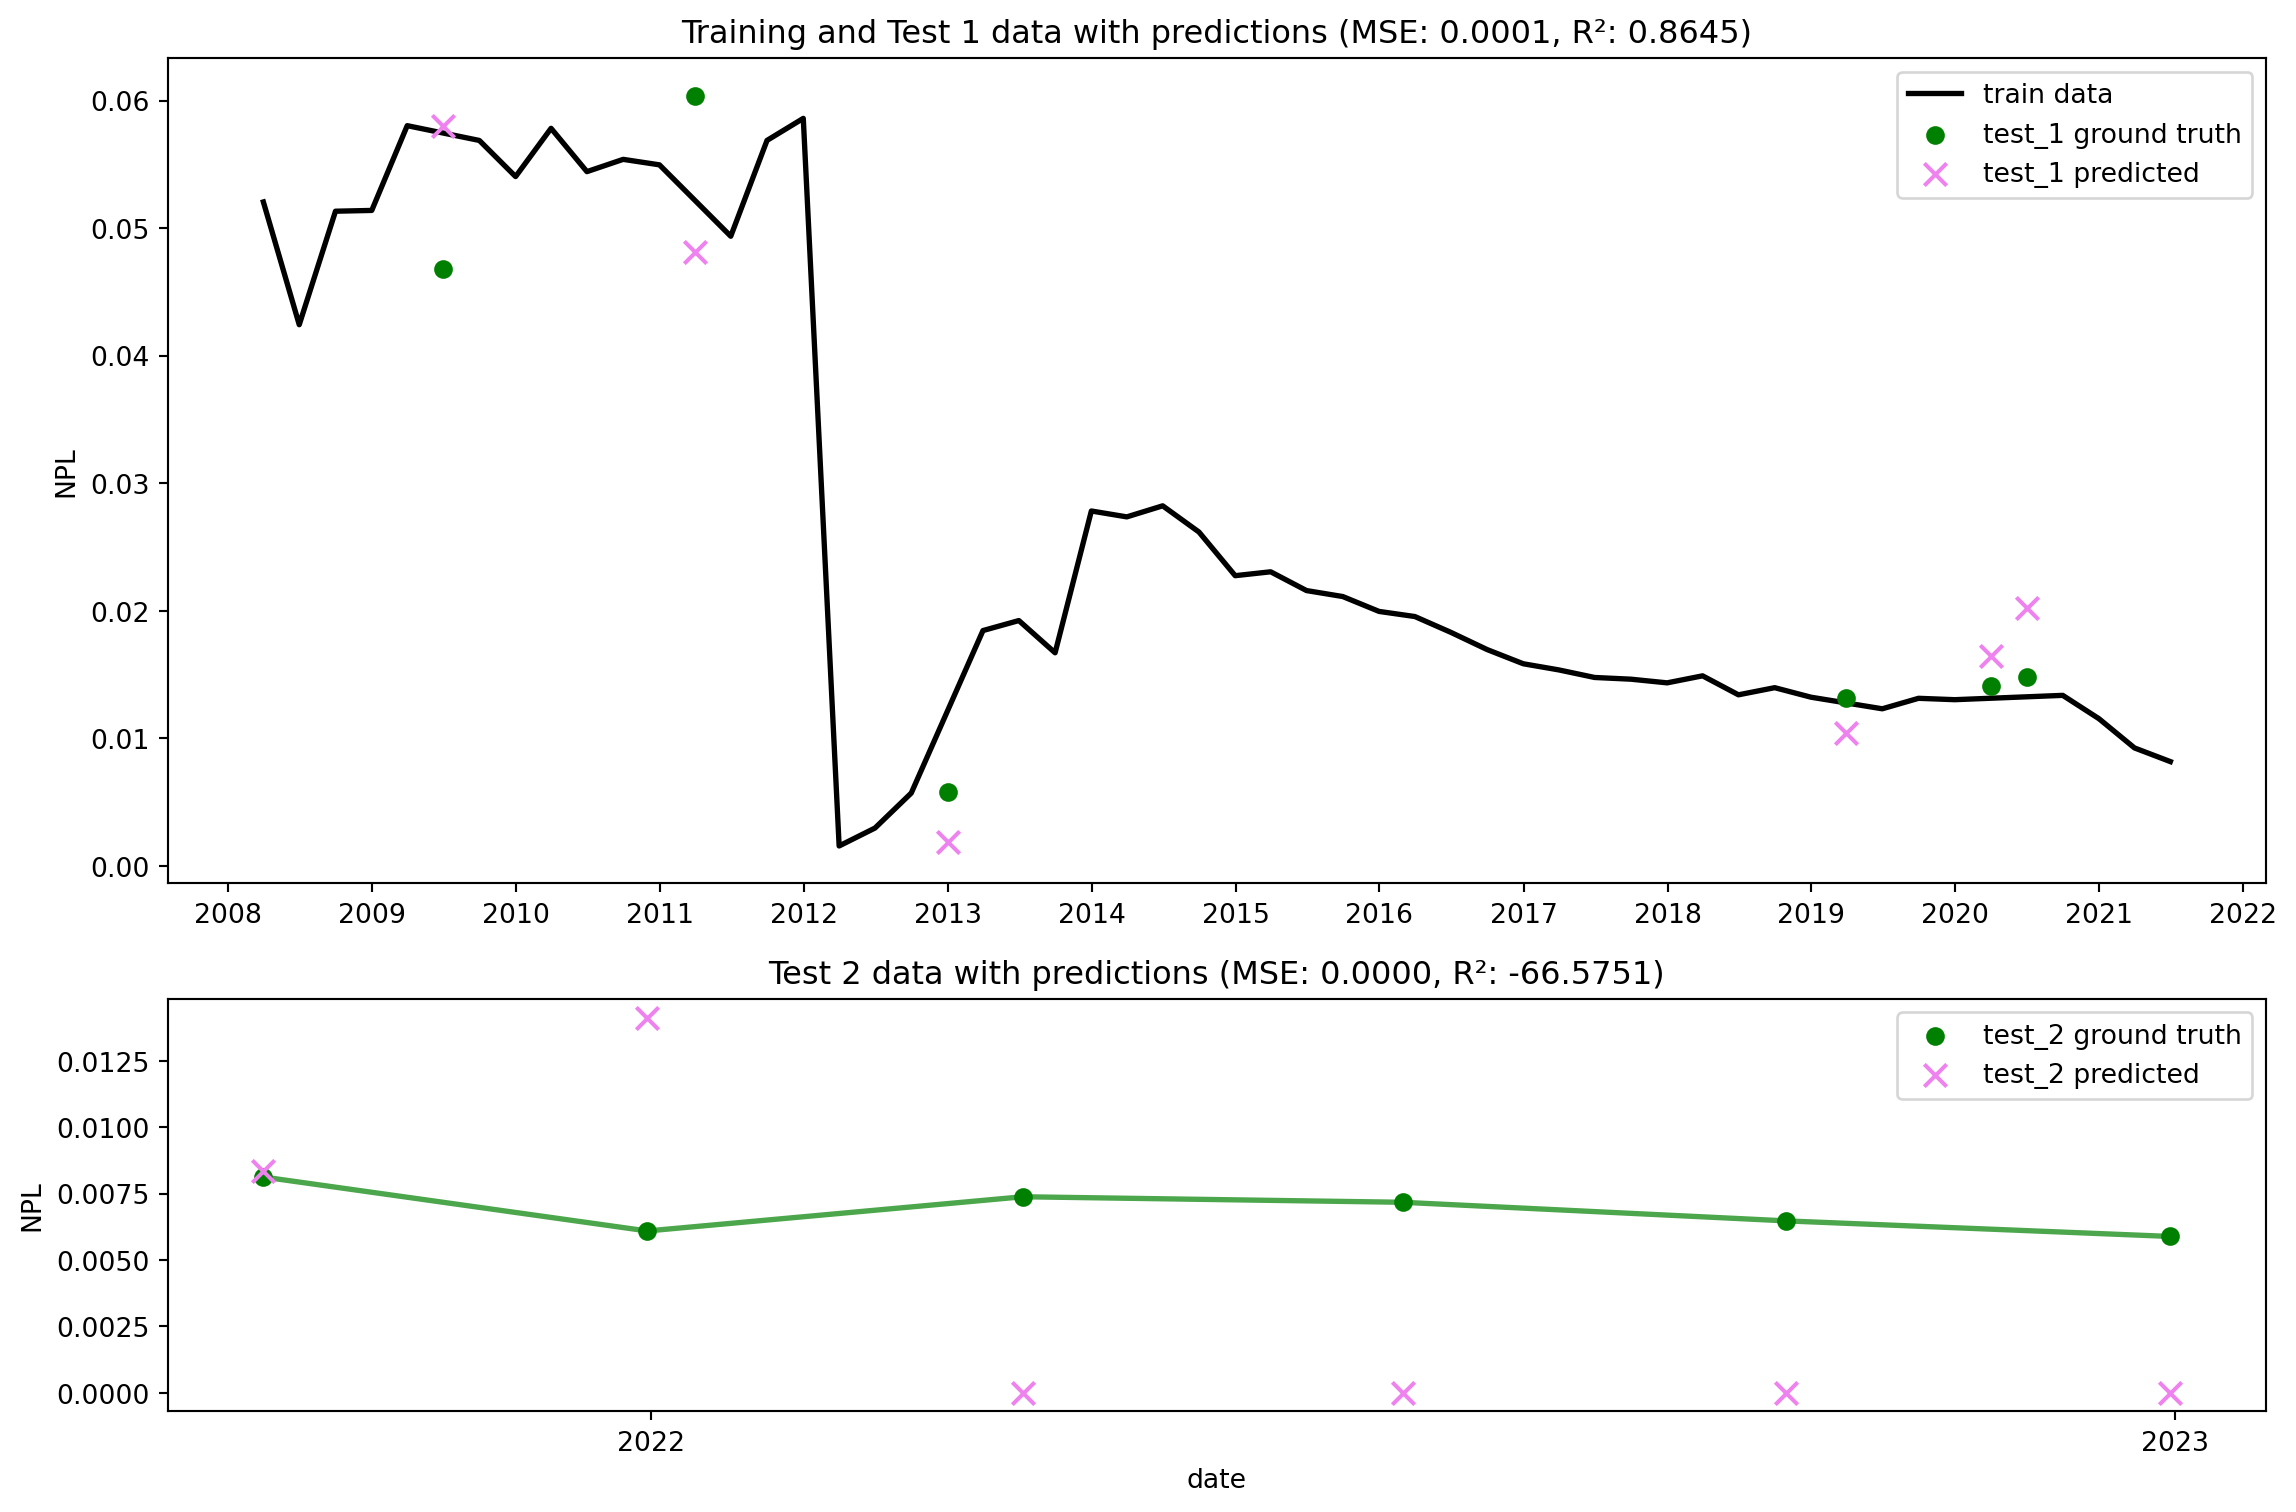

In [4]:
def train_test_split(data, test_1_size=6, test_2_size=6, random_state=None):
    """
    Splits the data into three sets: training, test_1, and test_2.

    - test_2: The last `test_2_size` rows of the data (chronologically, for time series).
    - test_1: Random `test_1_size` rows from the remaining data (not including test_2).
    - train: The remaining data after removing both test splits.

    Parameters
    ----------
    data : pandas.DataFrame
        The complete dataset to split. Should have a time-based index if time-split is desired.
    test_1_size : int, optional
        Number of rows to sample randomly for the first test set.
    test_2_size : int, optional
        Number of final rows for the second test set (default 6).
    random_state : int, optional
        Random seed for reproducibility of the random sample.

    Returns
    -------
    data_train : pandas.DataFrame
        The training data (with neither test_1 nor test_2 rows).
    data_test_1 : pandas.DataFrame
        Random sample from the remaining data (after taking off test_2).
    data_test_2 : pandas.DataFrame
        The last `test_2_size` rows of the input data.
    """

    # Make a copy of the input data to avoid mutating the original dataframe
    data_copy = data.copy()
    
    # The last `test_2_size` entries are reserved for the second test split (chronological holdout)
    data_test_2 = data_copy.tail(test_2_size)
    
    # Remove test_2 entries from the data copy to create a pool for training and test_1 split
    data_remaining = data_copy.iloc[:-test_2_size]
    
    # Randomly sample `test_1_size` rows from the remaining data to create the first test split
    data_test_1 = data_remaining.sample(n=test_1_size, random_state=random_state)
    
    # The rows not in the first or second test splits form the training data
    data_train = data_remaining.drop(data_test_1.index)
    
    # Return the three splits in order: training, test_1, test_2
    return data_train, data_test_1, data_test_2



def fit_linear_model_with_time_delay(data):
    """
    Fit a linear regression model to the data, using all columns except 'npl' as predictors
    and 'npl' as the target variable.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the feature columns and an 'npl' column as target.

    Returns
    -------
    model : LinearRegression
        Fitted linear regression model.
    """
    y = data['npl']                    # Target variable
    x = data.drop(columns=['npl'])     # Predictor variables
    model = LinearRegression()         # Instantiate linear regression
    model.fit(x, y)                    # Fit model to data
    return model                       # Return trained model

def evaluate_linear_model(model, test_data):
    """
    Evaluate a fitted linear regression model on test data.
    Predicts the 'npl' value, clips predictions at zero, and computes evaluation metrics.

    Parameters
    ----------
    model : LinearRegression
        Fitted sklearn linear regression model.
    test_data : pandas.DataFrame
        DataFrame containing the features (same as train) and 'npl' column for ground truth.

    Returns
    -------
    y_pred : numpy.ndarray
        Model predictions for 'npl', clipped at zero.
    mse : float
        Mean squared error of predictions vs ground truth.
    r2 : float
        R^2 score of predictions vs ground truth.
    """
    y_true = test_data['npl']                  # Ground truth
    x_test = test_data.drop(columns=['npl'])   # Test predictors

    # Predict on test data
    y_pred = model.predict(x_test)

    y_pred = np.maximum(y_pred, 0)             # Clip predictions at zero (no negative NPL values)
    
    # Compute evaluation metrics
    mse = mean_squared_error(y_true, y_pred)   # Mean squared error
    r2 = r2_score(y_true, y_pred)              # R^2 score
        
    return y_pred, mse, r2                     # Return predictions and metrics


data_train, data_test_1, data_test_2 = train_test_split(data, test_1_size=6, test_2_size=6, random_state=42)
model = fit_linear_model_with_time_delay(data_train)

y_pred_test_1, mse_test_1, r2_test_1 = evaluate_linear_model(model, data_test_1)
y_pred_test_2, mse_test_2, r2_test_2 = evaluate_linear_model(model, data_test_2)

plot_npl_predictions(data_train, data_test_1, data_test_2, y_pred_test_1, mse_test_1, r2_test_1, y_pred_test_2, mse_test_2, r2_test_2)


**Figure 2.** Comparison of the predictions of the linear model with delay with the ground truth values and the training data. Above: The model captures well the crisis and the post crisis regimes of the NPL, achieving solid performance metrics scores. Below: The model is only able to predict two quartals into the furure. 

The model's coefficients reveal the importance of different variables at different time spans for the model prediction. Table 2 lists all the model coefficients. Figure 3 shows the coefficients in a log-linear plot allowing us to observe the importance of variables. Gross domestic product, Unemployment Rate and House price index are found to be the most important macroeconomic variables influencing the NPL. We also find that the value of the NPL in the previous quartal is extremely important - if the bank is doing well, that will typically not change overnight and vice versa, a nonstable situation can usually not be improved very rapidly. The exception are of course extreme macroeconomic events like crises and recoveries. 

In [5]:
df_coef, styled = plot_model_coefficients_table(model, data, target="npl")
styled  


,npl-1q,npl-2q,Gross domestic product (GDP) (2015 = 100)-0y,Gross domestic product (GDP) (2015 = 100)-1y,Gross domestic product (GDP) (percentage change on previous)-0y,Gross domestic product (GDP) (percentage change on previous)-1y,Unemployment Rate-0q,Unemployment Rate-1q,Unemployment Rate-2q,House price index (2015 = 100)-0q,House price index (2015 = 100)-1q,House price index (2015 = 100)-2q,Harmonised Index of Consumer Prices (annual rate of change)-0q,Harmonised Index of Consumer Prices (annual rate of change)-1q,Harmonised Index of Consumer Prices (annual rate of change)-2q,Private sectror credit flow-0y,Private sectror credit flow-1y,Money Market Interest Rate-0q,Money Market Interest Rate-1q,Money Market Interest Rate-2q,Consumer confidence indicator-0q,Consumer confidence indicator-1q,Consumer confidence indicator-2q
Coefficient,0.5103,-0.0656,-0.1094,0.0877,0.0410,-0.0030,0.0097,-0.0160,0.0055,0.0068,-0.0061,0.0148,-0.0049,-0.0121,0.0104,0.0041,0.0095,0.0043,-0.0060,-0.0042,0.0001,0.0052,-0.0007


**Table 2.** Model coefficients for all the variables and time delays. 

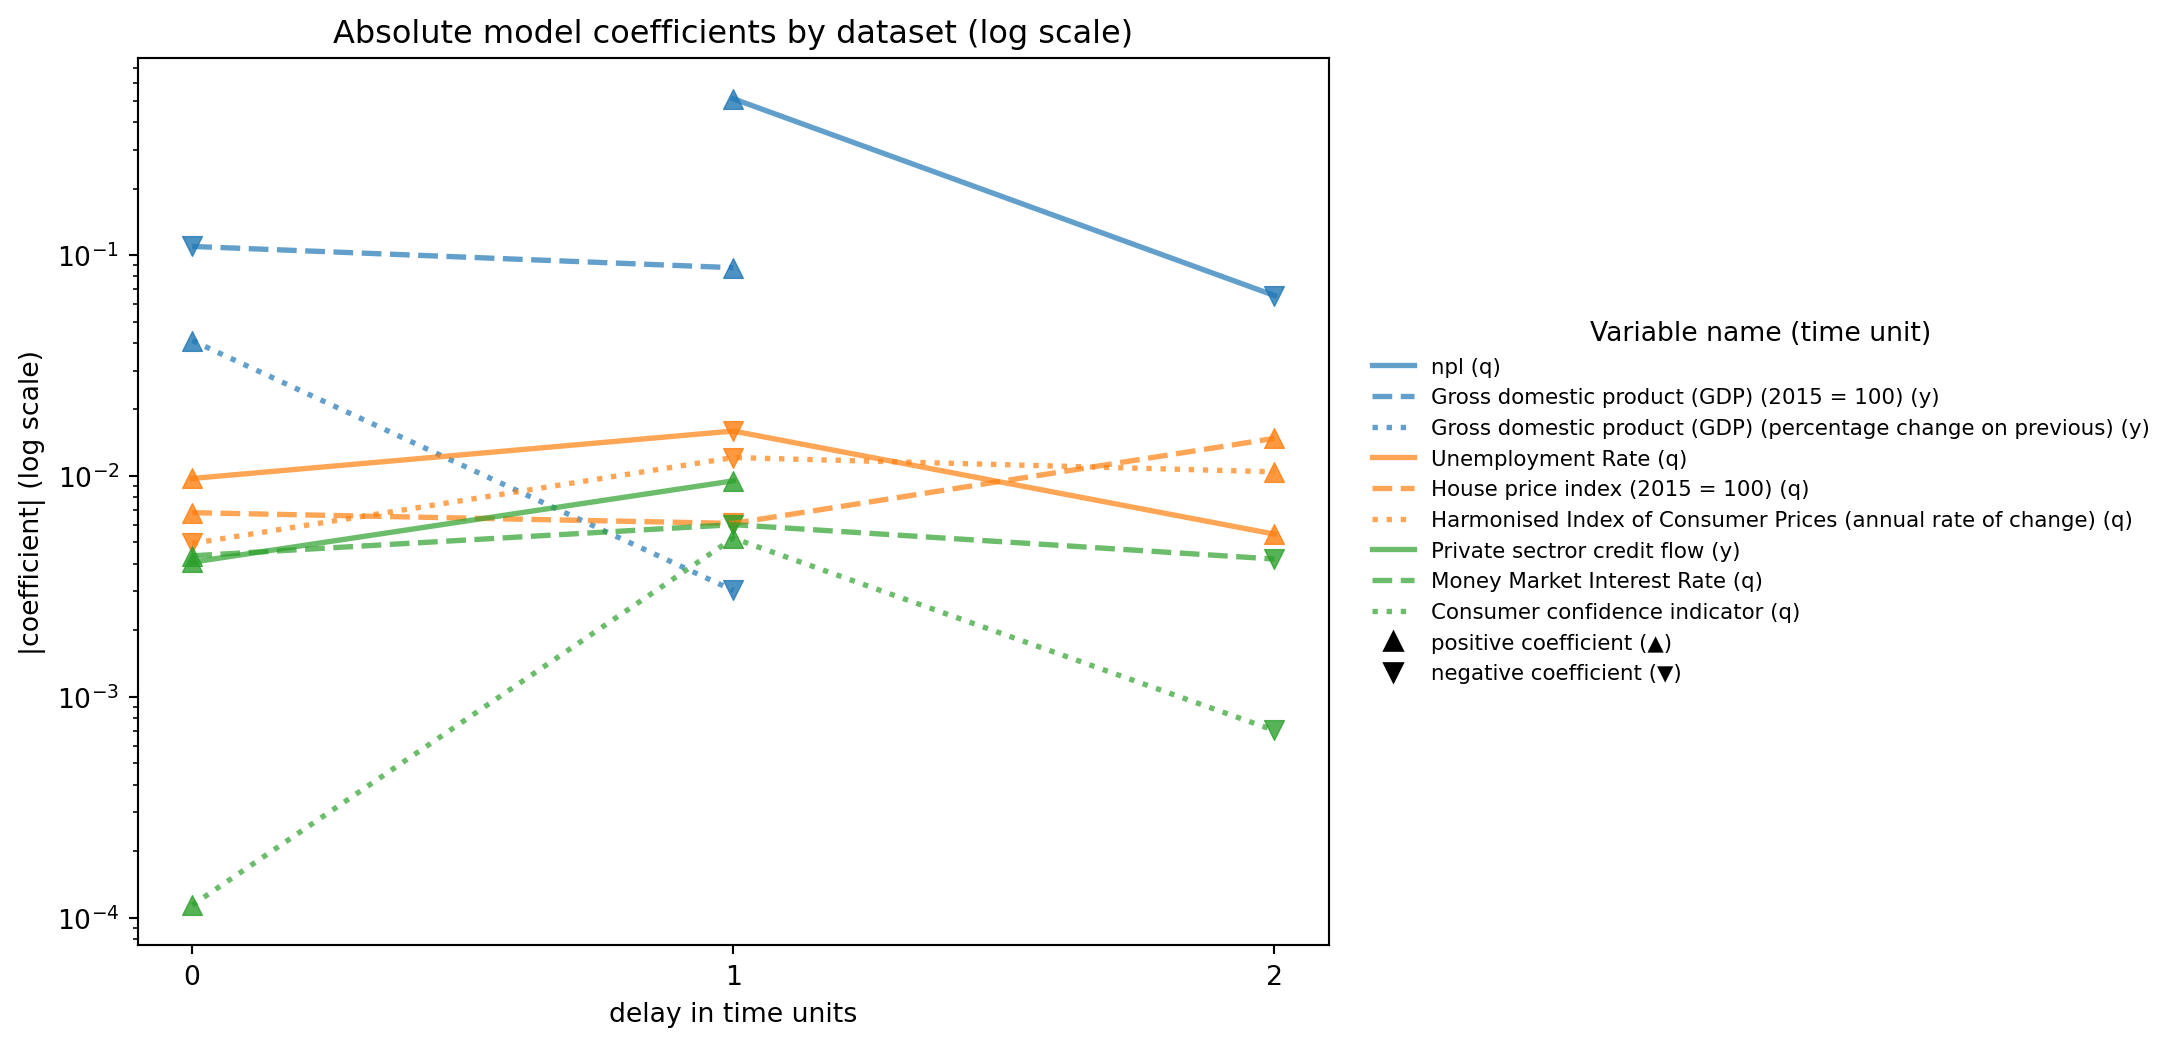

In [6]:
plot_abs_coeff_series_by_dataset(model, feature_names=data.drop(columns=['npl']).columns)

**Figure 3.** Comparison of the magnitudes of influence coefficients for different variables at different delays (see the Model section). The plot shows absolute values in a log-linear scale. Marker style denotes the sign of the coefficient as explained by the legend. We see that the previous values of the NPL and GDP are an order of magnitude more important than other macroeconomic variables. 

## Conclusions {.unnumbered}

In this study, we developed a linear delayed-action model to describe and predict the Non-Performing Loans (NPL) of Nova Ljubljanska Banka based on key macroeconomic variables. The model demonstrates strong explanatory power within the modelling period, achieving an $R^2$ score of 0.86, and successfully reproduces the main NPL regimes associated with the Euro crisis and the subsequent recovery period.

Our analysis identifies Gross Domestic Product, Unemployment Rate, and House Price Index as the primary macroeconomic drivers of NPL dynamics, reflecting the close link between credit risk and the broader economic environment. The inclusion of delayed terms proves essential for capturing the temporal dependencies in the data.

However, the model’s predictive capability is limited to approximately two quarters ahead, beyond which accuracy rapidly deteriorates. This limitation likely stems from the model’s linear nature and the relatively small dataset. Future work could explore nonlinear or hybrid approaches, incorporate additional regional data, or include stress-testing scenarios to improve robustness and forecasting horizons.
